<a href="https://colab.research.google.com/github/IsaD01/Deep-learning-/blob/Henry/Opdracht3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import cv2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO

Met behulp van requests de json data uit de huggingface gekregen. Door elk key te bekijken bevat 'rows' de data. Dit zit in een list en daarin heb je 'row', waarin de 'text' en 'image' in zit. 'text' bevat alleen 1 tekst per row en 'image' bevat 'src', 'height' en 'width'.

In [2]:
r = requests.get("https://datasets-server.huggingface.co/rows?dataset=tomytjandra%2Fh-and-m-fashion-caption-12k&config=default&split=train&offset=0&length=100")
r.json().keys()

dict_keys(['features', 'rows', 'num_rows_total', 'num_rows_per_page', 'partial'])

In [4]:
r.json()['rows'][1]['row']

{'text': 'melange dark grey trousers in sweatshirt fabric with an elasticated drawstring waist side pockets a back pocket and ribbed hems soft brushed inside',
 'image': {'src': 'https://datasets-server.huggingface.co/cached-assets/tomytjandra/h-and-m-fashion-caption-12k/--/d04b93f5405ccc14e898556b11ee2ee8b8f677ed/--/default/train/1/image/image.jpg?Expires=1716394672&Signature=g5gc4aH84XIKcDmmpuQJuDS4~ma4-1sz6hLKzqtXtMEvvku-lp9cjsY2LDkOHGqJaE9Ov2RDVr4fzdb6a2rFXUNJ2ffuLrteCMbQCUFwgXXBYWPoBEdj7gmIy8XWMBEe~YmHTWYctFUL1W~5Wty~lWDkFm5Xu0Jv5R33xmO0cIwSZ~aPaRg0rZCK9kbVD3l-MGr0tnzTCMD87645fgtAszndzFLHsIRNjP-qSnKF4OoYhhqpYks-tnUDpapPNAHjvj-7Mc6jPDN7VEhfqw9j50tz0BJNZQk21mPxkMty~JFehgzf~3Vll9VUceWVYrHc~N13vhiyntEMKGNOlzTxww__&Key-Pair-Id=K3EI6M078Z3AC3',
  'height': 1750,
  'width': 772}}

In [5]:
texts = []
images_details = []
for i in range(len(r.json()['rows'])):
  texts.append(r.json()['rows'][i]['row']['text'])
  images_details.append(r.json()['rows'][i]['row']['image'])

df_texts = pd.DataFrame(texts, columns=['text'])
df_images = pd.DataFrame(images_details)
dataframe = pd.concat([df_texts, df_images], axis=1)

In [6]:
dataframe

,text,src,height,width
0,solid dark blue fitted top in soft stretch jer...,https://datasets-server.huggingface.co/cached-...,1750,1531
1,melange dark grey trousers in sweatshirt fabri...,https://datasets-server.huggingface.co/cached-...,1750,772
2,solid black leggings in soft jersey with a wid...,https://datasets-server.huggingface.co/cached-...,1750,1166
3,solid black short padded jacket with a jersey-...,https://datasets-server.huggingface.co/cached-...,1750,1166
4,solid black harem trousers in jersey with elas...,https://datasets-server.huggingface.co/cached-...,1750,1166
...,...,...,...,...
95,solid black joggers in sweatshirt fabric with ...,https://datasets-server.huggingface.co/cached-...,1750,1166
96,all over pattern light orange long-sleeved nur...,https://datasets-server.huggingface.co/cached-...,1750,1166
97,solid black joggers in lightweight sweatshirt ...,https://datasets-server.huggingface.co/cached-...,1750,1166
98,all over pattern other sleeveless dress in a c...,https://datasets-server.huggingface.co/cached-...,1750,1166


In [10]:
img_name = []
img_list = []

os.makedirs("Images", exist_ok=True)

for url in dataframe['src']:
  r = requests.get(url, stream=True)
  file_name = os.path.basename(url)
  file_path = os.path.join("Images", file_name)

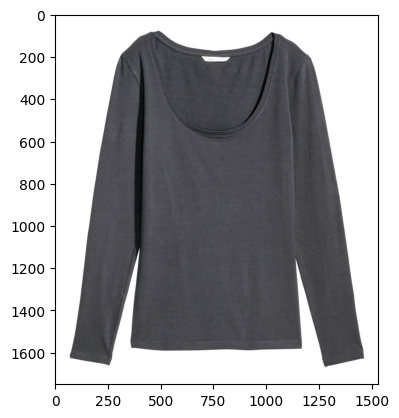

Image shape: (1750, 1531, 3)


In [20]:
response = requests.get(dataframe['src'][0])
response.raise_for_status()  # Check for HTTP errors

# Convert the response content to an image
img = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(img)
plt.show()

img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Get and print the shape of the image
img_shape = img_cv.shape
print(f"Image shape: {img_shape}")